# Dynamic reporting for gap analysis

This document generates dynamic reports of some of the main contents of the barcode reference database.

In [111]:
import sys
import math
# sys.path.insert(0,'/home/jovyan/work/src/')
sys.path.insert(0,'/home/jovyan/work/src/arise/barcode/metadata')
from sqlalchemy import create_engine, MetaData, select, func, case, and_
from sqlalchemy.orm import sessionmaker
from orm.barcode import Barcode
from orm.marker import Marker
from orm.nsr_species import NsrSpecies
from orm.nsr_synonym import NsrSynonym
from orm.nsr_node import NsrNode
from orm.specimen import Specimen
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from ete3 import Tree, TreeStyle, NodeStyle, RectFace, AttrFace, TextFace, faces
import os
from ipywidgets import IntProgress
from IPython.display import display
from enum import IntEnum
# import qgrid

os.environ['QT_QPA_PLATFORM']='offscreen'  # to avoid to kill the kernel using ete render
os.environ['XDG_RUNTIME_DIR']='/tmp/runtime-jovyan'

In [2]:
engine = create_engine('sqlite:////home/jovyan/work/data/sqlite/arise-barcode-metadata.db', echo=False)

# make session
Session = sessionmaker(engine)
session = Session()

## Marker diversity

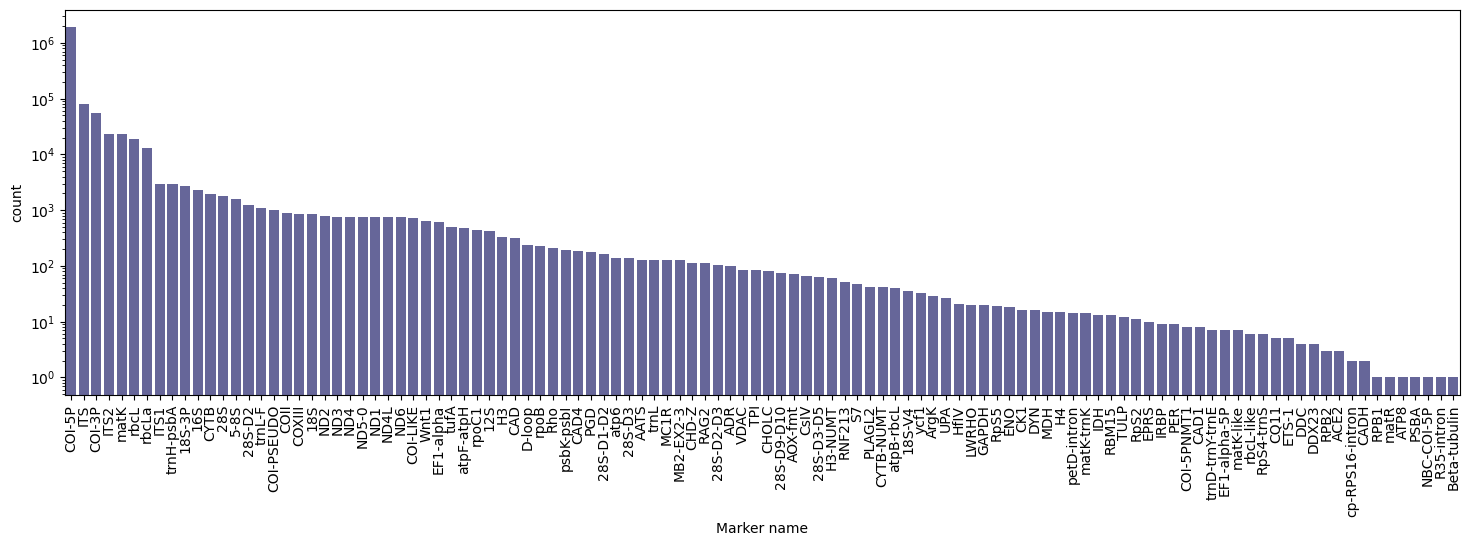

In [3]:
nsr_barcodes = session.query(Barcode).all()
data = [el.marker.name for el in nsr_barcodes]
df = pd.DataFrame(data, columns=['Marker name'])
fig, ax = plt.subplots(figsize=(18,5))
sb.countplot(data=df, x='Marker name', ax=ax, color='b', saturation=0.2, order = df['Marker name'].value_counts().index)
ax.set_yscale('log')
ax.tick_params(axis="x", rotation=90)

## Number of specimens per institutions

<Axes: xlabel='count', ylabel='Institution'>

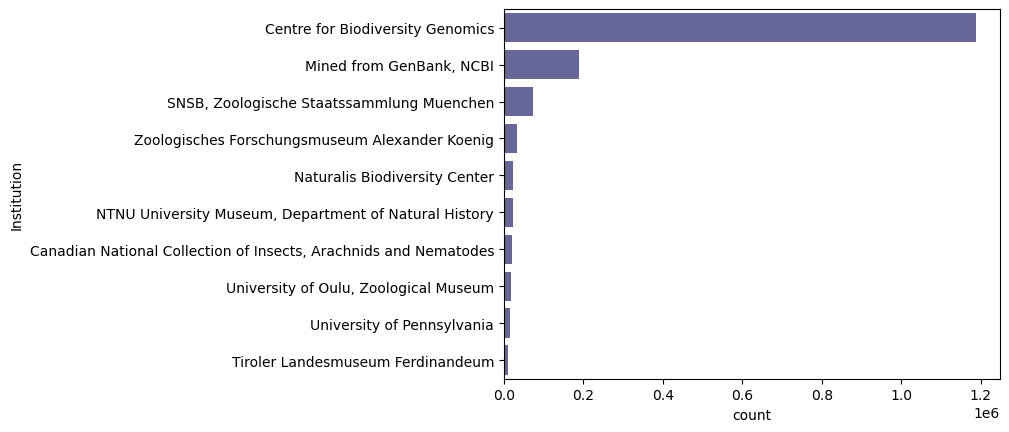

In [4]:
institutions = session.query(Specimen.institution_storing).all()
institutions = [e[0] for e in institutions if e[0]]
df = pd.DataFrame(institutions, columns=['Institution'])
indices = df['Institution'].value_counts().index
sb.countplot(data=df, y='Institution', color='b', saturation=0.2, order = indices[0:10])

In [5]:
# here we fetch the root across all of the Dutch Species Registry
nsr_root = NsrNode.get_root(session)
nsr_kingdoms = NsrNode.get_root(session).get_children(session)
kingdom_root_nodes = { n.name:n for n in nsr_kingdoms.all()[:3] }
# print(kingdom_root_nodes)

In [6]:
# we will now mirror this tree to an object we can draw, collapsing everything below max_rank
max_rank = 'order'
ete_tree_of_life = nsr_root.to_ete(session, until_rank=max_rank, remove_empty_rank=True, remove_incertae_sedis_rank=True)

# because this is a costly traversal we now cache the result so that we can subsequently skip this cell
%store ete_tree_of_life

Stored 'ete_tree_of_life' (TreeNode)


In [16]:
# here we restore the stored tree
%store -r ete_tree_of_life

color_range = ['#FF0000', '#0000FF', '#00FF00', '#FFFF00']  # red, blue, gree, yellow
rank_hierarchy = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']


class DataSource(IntEnum):
    NATURALIS = 1
    BOLD = 2
    NCBI = 3
    WFBI = 4
    UNITE = 5


# build an ordered list of highter taxon for the given node leaf
def make_ancestors_list(node, max_rank):
    """
        build an ordered list of taxon name from ancestor nodes
    """
    l = [None] * (rank_hierarchy.index(max_rank) + 1)
    for e in node.get_ancestors():
        if e._up is None or not hasattr(e, 'rank') or e.rank == 'life':
            continue
        l[rank_hierarchy.index(e.rank)] = e.name
    # add also the current node name in the list
    l[rank_hierarchy.index(node.rank)] = node.name
    return l
    

def get_color(value):
    round_value = int(value * 10) // 10
    return color_range[min(round_value, len(color_range) - 1)]


def get_species_barcode_count(session, filter_species):
    """
        get the number of barcode per species id
    """
    if filter_species:
        query = (session.query(
            Specimen.species_id,
            func.count(),
            func.sum(case(
                (Barcode.database.in_([DataSource.NATURALIS, DataSource.WFBI]), 1),  # ARISE barcodes
                else_=0
            )),
            func.sum(case(
                (Barcode.database.not_in([DataSource.NATURALIS, DataSource.WFBI]), 1),  # Other barcodes
                else_=0
            ))
        ).join(Barcode, Barcode.specimen_id == Specimen.id)
         .join(NsrSpecies, NsrSpecies.id == Specimen.species_id)
            .where(
                and_(
                    NsrSpecies.canonical_name.not_like("% sp."),
                    NsrSpecies.occurrence_status.in_(["0a", "1", "1a", "1b", "2a", "2b", "2c", "2d"]),
                )
            ).group_by(Specimen.species_id))
    else:
        query = session.query(
            Specimen.species_id,
            func.count(),
            func.sum(case(
                (Barcode.database.in_([DataSource.NATURALIS, DataSource.WFBI]), 1),  # ARISE barcodes
                else_=0
            )),
            func.sum(case(
                (Barcode.database.not_in([DataSource.NATURALIS, DataSource.WFBI]), 1),  # Other barcodes
                else_=0
            ))
        ).join(Barcode).group_by(Specimen.species_id)
    return {e: [ab, nb, ob] for e, ab, nb, ob in query.all()}


def get_specimen_locality(session, filter_species):
    fix_locality_dict = {
        'USA': "United State of America",
        'United States': "United State of America",
        'Faeroe Islands': 'Faroe Islands'
    }
    if filter_species:
        query = (session.query(
            Specimen.species_id,
            func.group_concat(Specimen.locality.distinct())
        ).join(NsrSpecies, NsrSpecies.id == Specimen.species_id)
         .where(
            and_(
                NsrSpecies.canonical_name.not_like("% sp."),
                NsrSpecies.occurrence_status.in_(["0a", "1", "1a", "1b", "2a", "2b", "2c", "2d"])
            )
        ).group_by(Specimen.species_id))
    else:
        query = (session.query(
            Specimen.species_id,
            func.group_concat(Specimen.locality.distinct())
        ).join(NsrSpecies).group_by(Specimen.species_id))
    d = dict()
    for e, loc in query.all():
        loc = '; '.join(
            [fix_locality_dict[c] if c in fix_locality_dict else c for c in sorted(loc.split(','))]
        )
        d[e] = loc
    return d


def get_species_occ_status(session, filter_species):
    query = session.query(
        NsrSpecies.id,
        NsrSpecies.occurrence_status
    )
    if filter_species:
        (query.join(NsrSpecies, NsrSpecies.id == Specimen.species_id)
              .where(
                  and_(
                      NsrSpecies.canonical_name.not_like("% sp."),
                      NsrSpecies.occurrence_status.in_(["0a", "1", "1a", "1b", "2a", "2b", "2c", "2d"])
                  )
              )
          )
    return {e: ocs for e, ocs in query.all()}


def add_features(node, total_sp, sp_with_bc, sp_with_bc_arise, sp_with_bc_not_arise, total_bc, arise_bc, not_arise_bc):
    """
        add multi ete feature to node
        (to replace with ete3.TreeNode.add_features?)
    """
    node.add_feature('total_sp', total_sp)
    node.add_feature('sp_with_bc', sp_with_bc)
    node.add_feature('sp_with_bc_arise', sp_with_bc_arise)
    node.add_feature('sp_with_bc_not_arise', sp_with_bc_not_arise)
    node.add_feature('total_bc', total_bc)
    node.add_feature('arise_bc', arise_bc)
    node.add_feature('not_arise_bc', not_arise_bc)


# does postorder traversal, propagating total species and total barcodes from tips to root
def add_count_features(session, tree, max_rank, filter_species) -> list:
    """
    :param session: SQLite session
    :param tree: ETE tree of life
    :param max_rank: the lowest rank level to consider
    :param filter_species: see argument parser description :p
    :return: Coverage table
    """
    species_bc_dict = get_species_barcode_count(session, filter_species)
    specimen_loc_dict = get_specimen_locality(session, filter_species)
    species_occ_status_dict = get_species_occ_status(session, filter_species)

    """
    does postorder traversal, propagating total species and total barcodes from tips to root
    compute the coverage (% of species with barcodes) at each taxon level
    for all barcodes, ARISE barcodes, non-ARISE barcodes
    """
    coverage_table = []
    for node in tree.iter_descendants(strategy='postorder'):
        total_sp = 0  # total species
        sp_with_bc = 0  # species with barcode(s)
        sp_with_bc_arise = 0  # species with barcode(s) from ARISE
        sp_with_bc_not_arise = 0  # species with barcode(s) from inst. other than ARISE
        total_bc = 0  # total number of barcodes
        arise_bc = 0  # total number of ARISE barcodes
        not_arise_bc = 0  # total number of not ARISE barcodes
        coverage = 0  # percentage of species having at least one barcode
        coverage_arise = 0  # percentage of species with barcode(s) from ARISE.
        coverage_not_arise = 0  # etc
        occurrence_status = None
        locality = None
        if node.rank == max_rank:
            if max_rank == 'species':
                # special case, species is the max level, meaning the number of species = 1
                total_sp = 1
                nsr_node = session.query(NsrNode).filter(NsrNode.id == node.id).first()
                if nsr_node.species_id and nsr_node.species_id in species_occ_status_dict:
                    occurrence_status = species_occ_status_dict[nsr_node.species_id]

                # remove species without left and right index
                # TODO debug such cases!
                if nsr_node.species_id is None or (nsr_node.left == nsr_node.right and nsr_node.right is None):
                    add_features(node, 0, 0, 0, 0, 0, 0, 0)
                    continue

                if filter_species and (
                        nsr_node.name.endswith(" sp.") or
                        occurrence_status not in ["0a", "1", "1a", "1b", "2a", "2b", "2c", "2d"]
                    ):
                    add_features(node, 0, 0, 0, 0, 0, 0, 0)
                    continue

                if nsr_node.species_id and nsr_node.species_id in species_bc_dict:
                    total_bc, arise_bc, not_arise_bc = species_bc_dict[nsr_node.species_id]
                    sp_with_bc = 1
                    sp_with_bc_arise = 1 if arise_bc else 0
                    sp_with_bc_not_arise = 1 if not_arise_bc else 0
                    coverage = 100
                    coverage_arise = sp_with_bc_arise * 100
                    coverage_not_arise = sp_with_bc_not_arise * 100
                if nsr_node.species_id and nsr_node.species_id in specimen_loc_dict:
                    locality = specimen_loc_dict[nsr_node.species_id]

            else:
                tips = session.query(NsrNode).filter(NsrNode.id == node.id).first().get_leaves(session).all()
                if len(tips) != 0:
                    total_sp = len(tips)
                    sp_with_bc_arise = 0
                    sp_with_bc_not_arise = 0
                    for tip in tips:
                        if tip.species_id and tip.species_id in species_bc_dict:
                            c_total_bc, c_arise_bc, c_not_arise_bc = species_bc_dict[tip.species_id]
                            total_bc += c_total_bc
                            arise_bc += c_arise_bc
                            not_arise_bc += c_not_arise_bc
                            sp_with_bc += 1
                            sp_with_bc_arise += 1 if c_arise_bc else 0
                            sp_with_bc_not_arise += 1 if c_not_arise_bc else 0

                    if total_sp != 0:
                        coverage = sp_with_bc / len(tips) * 100
                        coverage_arise = sp_with_bc_arise / len(tips) * 100
                        coverage_not_arise = sp_with_bc_not_arise / len(tips) * 100

                    if coverage != 0:
                        # get a color from the number of barcode / per species
                        color = get_color(math.log10(len(tips)))
                        rf = RectFace(coverage*3, 80, color, color)
                    else:
                        rf = RectFace(1, 80, "#FFFFFF", "#FFFFFF")
                    rf.background.color = "#FFFFFF"
                    rf.inner_background.color = "#FFFFFF"
                    rf.inner_border.color = "#FFFFFF"
                    node.add_face(rf, column=1, position="aligned")
                    # black line to show the max limit of coverage
                    rfl = RectFace(1, 80, 'black', 'black')
                    node.add_face(rfl, column=2, position="aligned")
        
        else:
            for child in node.get_children():
                total_sp += child.total_sp
                sp_with_bc += child.sp_with_bc
                sp_with_bc_arise += child.sp_with_bc_arise
                sp_with_bc_not_arise += child.sp_with_bc_not_arise
                total_bc += child.total_bc
                arise_bc += child.arise_bc
                not_arise_bc += child.not_arise_bc

            if total_sp != 0:
                coverage = sp_with_bc / total_sp * 100
                coverage_arise = sp_with_bc_arise / total_sp * 100
                coverage_not_arise = sp_with_bc_not_arise / total_sp * 100

        add_features(node, total_sp, sp_with_bc, sp_with_bc_arise, sp_with_bc_not_arise, total_bc, arise_bc, not_arise_bc)
        if node.name != "All of life":
            coverage_table.append(make_ancestors_list(node, max_rank) +
                                                              [node.rank, total_sp, sp_with_bc,
                                                               total_bc, coverage,
                                                               arise_bc, coverage_arise,
                                                               not_arise_bc, coverage_not_arise,
                                                               locality, occurrence_status])

    # finally also do the tree root itself
    total_sp = 0
    sp_with_bc = 0
    sp_with_bc_arise = 0
    sp_with_bc_not_arise = 0
    total_bc = 0
    arise_bc = 0
    not_arise_bc = 0
    for child in tree.get_children():
        total_sp += child.total_sp
        sp_with_bc += child.sp_with_bc
        sp_with_bc_arise += child.sp_with_bc_arise
        sp_with_bc_not_arise += child.sp_with_bc_not_arise
        total_bc += child.total_bc
        arise_bc += child.arise_bc
        not_arise_bc += child.not_arise_bc

    add_features(tree, total_sp, sp_with_bc, sp_with_bc_arise, sp_with_bc_not_arise, total_bc, arise_bc, not_arise_bc)

# does postorder traversel, propagating total species and total barcodes from tips to root
def add_count_features_old(tree, max_rank, species_bc_dict):
    coverage_table = []
    for node in tree.iter_descendants(strategy='postorder'):
        if node.rank == max_rank:
            # print(node.id, node.rank, node.name)
            tips = session.query(NsrNode).filter(NsrNode.id == node.id).first().get_leaves(session).all()
            total_bc = 0
            sp_with_bc = 0
            for tip in tips:
                if tip.species_id and tip.species_id in species_bc_dict:
                    total_bc += species_bc_dict[tip.species_id]
                    sp_with_bc += 1
            node.add_feature('total_sp', len(tips))
            node.add_feature('sp_with_bc', sp_with_bc)
            node.add_feature('total_bc', total_bc)
            
            
            coverage = sp_with_bc/len(tips)*100
            if coverage != 0:
                # get a color from the number of barcode / per species
                color = get_color(math.log10(len(tips)))
                rf = RectFace(coverage*3, 80, color, color)
            else:
                rf = RectFace(1, 80, "#FFFFFF", "#FFFFFF")
            rf.background.color = "#FFFFFF"
            rf.inner_background.color = "#FFFFFF"
            rf.inner_border.color = "#FFFFFF"
            node.add_face(rf, column=1, position="aligned")
            # black line to show the max limit of coverage
            rfl = RectFace(1, 80, 'black', 'black')
            node.add_face(rfl, column=2, position="aligned")
                
            coverage_table.append(make_ancestors_list(node) + [node.name, len(tips), sp_with_bc, total_bc, coverage])


        else:
            total_sp = 0
            total_bc = 0
            sp_with_bc = 0
            for child in node.get_children():
                total_sp += child.total_sp
                total_bc += child.total_bc
                sp_with_bc += child.sp_with_bc
            node.add_feature('total_sp', total_sp)
            node.add_feature('sp_with_bc', sp_with_bc)
            node.add_feature('total_bc', total_bc)
            
    # finally also do the tree root itself
    total_sp = 0
    total_bc = 0
    sp_with_bc = 0
    for child in tree.get_children():
        total_sp += child.total_sp
        total_bc += child.total_bc
        sp_with_bc += child.sp_with_bc
    tree.add_feature('total_sp', total_sp)
    tree.add_feature('sp_with_bc', sp_with_bc)
    tree.add_feature('total_bc', total_bc)
    
    return coverage_table

    
# # prefetches the number of barcodes per species_id as dict
# def get_species_barcode_count():
#     query = session.query(Specimen.species_id, func.count()).join(Barcode).group_by(Specimen.species_id)
#     return { e:c for e, c in query.all() }


# def get_species_wo_barcode():
#     query = session.query(Specimen.species_id, func.count()).join(Barcode).group_by(Specimen.species_id)
#     return { e:c for e, c in query.all() }


def my_layout(node):
    if node.is_leaf():
        if node.name:
            name_face = AttrFace("name", fsize=48, ftype="Consolas")
            name_face.margin_right = 10
            name_face.margin_left = 10
            name_face.hz_align = 2  # right aligned
            faces.add_face_to_node(name_face, node, column=0, position="aligned")
        else:
            return
        
    elif node.name:
        name_face = AttrFace("name", fsize=32, ftype="Consolas", fgcolor="#FFFFF", formatter='%-20s')
        name_face.margin_right = 10
        name_face.margin_left = 10
        faces.add_face_to_node(name_face, node, column=0)
    else:
        return

def get_tree_style(title, title_fsize=400, legend_fsize=200):
    circular_style = TreeStyle()
    circular_style.layout_fn = my_layout
    circular_style.mode = "c" # draw tree in circular mode
    circular_style.show_leaf_name = False
    circular_style.draw_guiding_lines = False
    circular_style.min_leaf_separation = 0
    if title and title_fsize != 0:
        circular_style.title.add_face(TextFace(title, fsize=title_fsize), column=0)
    
    # add legend 
    if legend_fsize != 0:
        circular_style.legend.add_face(TextFace("#", fsize=legend_fsize), column=0)
        circular_style.legend.add_face(TextFace("Species count ", fsize=legend_fsize), column=1)
        circular_style.legend.add_face(TextFace("per order", fsize=legend_fsize), column=2)

        i = 0
        range_strs = ["0-9", "10-99","100-999","1000+"]
        for color in color_range:
            rf = RectFace(legend_fsize, legend_fsize, color, color)
            circular_style.legend.add_face(rf, column=0)
            tf = TextFace(range_strs[i], fsize=legend_fsize)
            tf.margin_left = legend_fsize // 2
            circular_style.legend.add_face(tf, column=1)
            i += 1
    # circular_style.force_topology = True
    return circular_style

    
# run the above functions to calculate subtended barcodes/species on all nodes
# d = get_species_barcode_count()

## Barcode coverage (all families)

In [17]:
#coverage_table = add_count_features(ete_tree_of_life, max_rank, d)
# coverage_table = add_count_features(session, ete_tree_of_life, max_rank, True)
# tree_style = get_tree_style("", 0, 800)  # font size > ~1200 is ignoring the whitespace characters?
# ete_tree_of_life.render(file_name='%%inline', w=1200, tree_style=tree_style)

## Barcode coverage - Animalia families

In [19]:
ete_tree_animalia = kingdom_root_nodes['Animalia'].to_ete(session, until_rank=max_rank, remove_empty_rank=True, remove_incertae_sedis_rank=True)
# add_count_features(ete_tree_animalia, max_rank, d)
add_count_features(session, ete_tree_animalia, max_rank, True)
tree_style = get_tree_style("", 400, 100)
ete_tree_animalia.render(file_name='%%inline', w=1200, tree_style=tree_style)
ete_tree_animalia.render(file_name='image.png', w=1200, tree_style=tree_style)

{'nodes': [[549.7984974632911,
   589.9998226144432,
   550.2255637472555,
   590.4268888984076,
   0,
   None],
  [499.7322667840372,
   580.2429720754479,
   500.15933306800156,
   580.6700383594123,
   1,
   None],
  [784.7455731430802,
   682.6819136109,
   785.2268281853163,
   683.1631686531363,
   2,
   None],
  [900.7145820700986,
   640.3525784323762,
   901.1241440043299,
   640.7621403666076,
   3,
   None],
  [1004.3690077633127,
   599.7619829183277,
   1004.7331452845095,
   600.1261204395246,
   4,
   None],
  [1004.2912784847181,
   607.5108338799603,
   1004.6623260674695,
   607.8818814627118,
   5,
   None],
  [1004.06509609343,
   615.2569067531177,
   1004.4429175103432,
   615.6347281700308,
   6,
   None],
  [1003.6905436306506,
   622.9973576240717,
   1004.0750001673689,
   623.3818141607899,
   7,
   None],
  [1003.1677586105649,
   630.7293446431713,
   1003.558709116696,
   631.1202951493025,
   8,
   None],
  [1002.4969329698499,
   638.4500290682062,
   10

## Barcode coverage - Plantae families

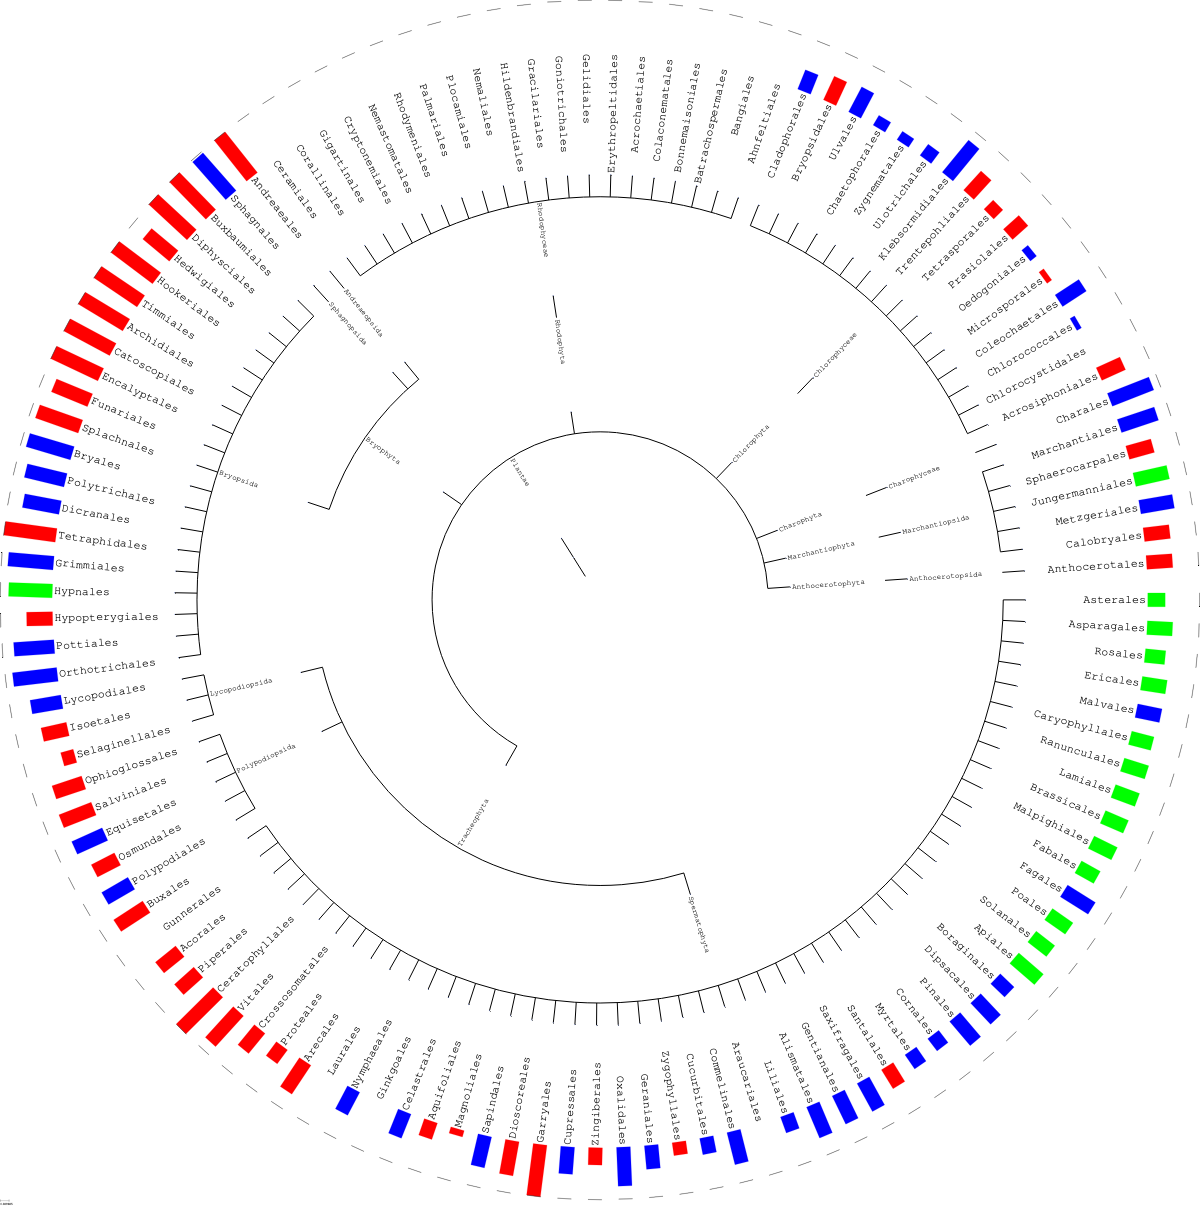

In [13]:
# nst1 = NodeStyle()
# nst1["bgcolor"] = "LightSteelBlue"
# nst2 = NodeStyle()
# nst2["bgcolor"] = "Moccasin"
# nst3 = NodeStyle()
# nst3["bgcolor"] = "DarkSeaGreen"
# nst4 = NodeStyle()
# nst4["bgcolor"] = "Khaki"

import colorsys
from ete3 import COLOR_SCHEMES, SVG_COLORS
test_color = colorsys.hsv_to_rgb(1,1,1)
from PIL import ImageColor

def rgb_to_hex(rgb):
    rgb = tuple(int(c) for c in rgb)
    return '#%02x%02x%02x' % rgb


def generate_color_variations(start_color, num_colors, hue_var, sat_var):
    colors = []
    for i in range(1, num_colors+1):
        hue_val = start_color[0]
        if hue_var != 0:
            hue_val = start_color[0] + (i * hue_var)
            if hue_val < 0:
                hue_val += 1
            elif hue_val > 1:
                hue_val -= 1
        
        sat_val = start_color[1]
        if sat_var != 0:
            sat_val = start_color[1] + (i * sat_var)
            if sat_val < 0:
                sat_val = 0
            elif sat_val > 1:
                sat_val = 1
        
        colors.append((hue_val, sat_val, start_color[2]))
    return colors
        
    


def color_tree(tree, kingdom_colors={'Animalea': '#ffd557', 'Plantae': "#0abd01", "Fungi": "#43adc0", "Amoebozoa": '#663db0', 'Chromista': '#ff58a2' }):
    c = 0
    # rgb = ImageColor.getcolor("#0abd01", "RGB")
    # hsv = list(colorsys.rgb_to_hsv(*rgb))
    # all_colors = generate_color_variations(hsv, 500, 0.001, 0.1)
    
    for node in tree.iter_descendants():
        if node.rank != max_rank and node.name in kingdom_colors:
            color = kingdom_colors[node.name]
        else:
            color = node.color
            
        ns = NodeStyle(fgcolor="#fffffe", bgcolor=color, faces_bgcolor="#fffffe", node_bgcolor="#fffffe", partition_bgcolor="#fffffe")
        node.set_style(ns)
        if node.rank == max_rank or node.rank == 'class':
            continue
        
        children = node.get_children()
        rgb = ImageColor.getcolor(color, "RGB")
        hsv = list(colorsys.rgb_to_hsv(*rgb))

        colors = generate_color_variations(hsv, len(children), 0.1, 0.01)

        for i, c in enumerate(children):
            if c.rank != max_rank or c.rank != 'class':
                c.color = rgb_to_hex(colorsys.hsv_to_rgb(*colors[i]))
            else:
                c.color = color
        c+=1

ete_tree_plantae = kingdom_root_nodes['Plantae'].to_ete(session, until_rank=max_rank, remove_empty_rank=True, remove_incertae_sedis_rank=True)
# color_tree(ete_tree_plantae)
add_count_features(session, ete_tree_plantae, max_rank, True)
# ete_tree_plantae.convert_to_ultrametric()
tree_style = get_tree_style("", 0, 0)
ete_tree_plantae.render(file_name='%%inline', w=1200, tree_style=tree_style)

## Barcode coverage - Fungi families

In [ ]:
ete_tree_fungi = kingdom_root_nodes['Fungi'].to_ete(session, until_rank=max_rank, remove_empty_rank=True, remove_incertae_sedis_rank=True)
coverage_table_fungi = add_count_features(session, ete_tree_fungi, max_rank, True)
tree_style = get_tree_style("", 0, 0)
ete_tree_fungi.render(file_name='%%inline', w=1200, tree_style=tree_style)

## Interactive table
(not available on github)

In [ ]:
df = pd.DataFrame(coverage_table, columns=['kingdom', "phylum", 'order', 'class', "family" , "# of species", "# of barcoded species","# of barcodes in family","% of species barcoded"])
table = qgrid.show_grid(df, precision=2)
table

In [ ]:
# This is the part where we have to play with ETE's options to make this cool. Ideas:
# - It should be possible to render the tree only up to a specified level, e.g.
#   'phylum' or 'class'. There are several challenges: 1) we have a lot of 'incertae sedis'
#   that are grafted on anonymous parents, 2) the ETE API behaves inpredictably, I
#   try to prune children below a specified level but nothing seems to happen, 3)
#   there appear to be cycles in the data structure (and database), probably due to
#   faulty DarwinCore output.
# - It should also be possible to render from another node than the root. I think 
#   that might just be matter of finding the right node and rendering from there,
#   e.g. showing all the Molluscs or whatever.
# - Visualizing the features (n tips, n barcodes) is possible through the 'faces',
#   example is here: https://www.biostars.org/p/153788/
# Nice to have but not essential:
# - Color coding would be nice for the clades. A way to do that is use HSV instead
#   of RGB, divide 360 by number of children's descendants (at root), then subdivide 
#   the segments further as you approach the tips.
# - It would be nice if we can collapse unbranched internal nodes, for monotypic
#   higher taxa.